In [64]:
import sys
import numpy as np
import keras
from keras.utils import Sequence
from PIL import Image
from matplotlib import pyplot as plt
import pandas as pd
from tqdm import tqdm
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import imgaug as ia
from imgaug import augmenters as iaa
import cv2

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Activation, Dropout, Flatten, Dense, Input, Conv2D, MaxPooling2D,Concatenate
from keras.layers import BatchNormalization, Concatenate, ReLU, LeakyReLU,GlobalAveragePooling2D, Average
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras_tqdm import TQDMNotebookCallback
from keras import metrics
from keras.optimizers import Adam, SGD,RMSprop
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import keras
import tensorflow as tf
import my_applications.inception_resnet_v2
import my_applications.xception
import my_applications.inception_v3
import my_applications.densenet
import my_applications.se_densenet
import my_applications.se_resnet
import my_applications.densenet_gn
import my_optimizer.AdamAccumulate as myopt
from keras.losses import binary_crossentropy,categorical_crossentropy,mean_squared_error
from tensorflow import set_random_seed
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
import gc
import warnings
from prefetch_generator import BackgroundGenerator, background
warnings.filterwarnings(action='ignore')

In [100]:
m1 = my_applications.densenet.DenseNet121(input_shape=(224,224,3), weights=None,include_top= True)
m2 = my_applications.densenet.DenseNet121(input_shape=(224,224,3), weights=None,include_top= True)
mi1 = Model(inputs=m1.input,outputs=m1.layers[-2].output)
mi2 = Model(inputs=m2.input,outputs=m2.layers[-2].output)

In [101]:
models = []
input_shape = (224,224,3)
model_input = Input(input_shape)
models.append(mi1)
models.append(mi2)

In [102]:
def ensembleModels(models, model_input):
    yModels=[model(model_input) for model in models] 
    yAvg=Concatenate()(yModels) 
    modelEns = Model(inputs=model_input, outputs=yAvg,    name='ensemble')  
    return modelEns

In [103]:
en_model = ensembleModels(models,model_input)
en_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 1024)         7037504     input_19[0][0]                   
__________________________________________________________________________________________________
model_3 (Model)                 (None, 1024)         7037504     input_19[0][0]                   
__________________________________________________________________________________________________
concatenate_16 (Concatenate)    (None, 2048)         0           model_2[1][0]                    
                                                                 model_3[1][0]                    
Total para

In [98]:
def ensemble_feature_vec(models, model_input):
    feature_models = []
    for idx, model in enumerate(models):
        print(model.name)
        intermediate_layer_model = Model(inputs=model.input,outputs=model.layers[-2].output)
        feature_models.append(intermediate_layer_model)
    features =[model(model_input) for model in feature_models]     
    y = Concatenate()(features)
    y = Dense(1000, activation='softmax', name='dummy_sf')(y)
    modelEns = Model(inputs=model_input, outputs=yAvg,    name='ensemble')     
    return modelEns
models = []
models.append(m1)
models.append(m2)
models


In [99]:
model_input = m1.inputs
en_model = ensemble_feature_vec(models,model_input)
en_model.save('./ensemble.h5')

m1


AttributeError: Layer m1 has multiple inbound nodes, hence the notion of "layer input" is ill-defined. Use `get_input_at(node_index)` instead.

In [2]:
TEST_LIST = []

TEST_LIST.append({'name':'Xception', 'shape':(512, 512, 4), 'backbone':my_applications.xception.Xception
                  , 'batchsize':8 , 'SEED':777, 'aug':True, 'cum_iter':30, 'learnig_rate':0.002, 'finetune_layer':70, 'fine_batchmul':15})
TEST_LIST.append({'name':'Xception', 'shape':(512, 512, 4), 'backbone':my_applications.xception.Xception
                  , 'batchsize':8 , 'SEED':790, 'aug':True, 'cum_iter':30, 'learnig_rate':0.002, 'finetune_layer':30, 'fine_batchmul':7})
TEST_LIST.append({'name':'InceptionResnetV2', 'shape':(512, 512, 4), 'backbone':my_applications.inception_resnet_v2.InceptionResNetV2
                  , 'batchsize':6 , 'SEED':189, 'aug':True, 'cum_iter':30, 'learnig_rate':0.002, 'finetune_layer':70, 'fine_batchmul':15})
TEST_LIST.append({'name':'Densenet121', 'shape':(512, 512, 4), 'backbone':my_applications.densenet.DenseNet121
                  , 'batchsize':8 , 'SEED':777, 'aug':True, 'cum_iter':30, 'learnig_rate':0.002, 'finetune_layer':70, 'fine_batchmul':15})
TEST_LIST.append({'name':'Densenet201', 'shape':(512, 512, 4), 'backbone':my_applications.densenet.DenseNet201
                  , 'batchsize':4 , 'SEED':777, 'aug':True, 'cum_iter':30, 'learnig_rate':0.002, 'finetune_layer':70, 'fine_batchmul':15})
TEST_LIST.append({'name':'Densenet169', 'shape':(512, 512, 4), 'backbone':my_applications.densenet.DenseNet169
                  , 'batchsize':7 , 'SEED':777, 'aug':True, 'cum_iter':30, 'learnig_rate':0.002, 'finetune_layer':70, 'fine_batchmul':15})
TEST_LIST.append({'name':'Densenet201GN', 'shape':(512, 512, 4), 'backbone':my_applications.densenet_gn.DenseNet201
                  , 'batchsize':4 , 'SEED':777, 'aug':True, 'cum_iter':30, 'learnig_rate':0.002, 'finetune_layer':70, 'fine_batchmul':15})
TEST_LIST.append({'name':'SeDensenet121', 'shape':(512, 512, 4), 'backbone':my_applications.se_densenet.SEDenseNetImageNet121
                  , 'batchsize':8 , 'SEED':777, 'aug':True, 'cum_iter':30, 'learnig_rate':0.002, 'finetune_layer':70, 'fine_batchmul':15})
TEST_LIST.append({'name':'InceptinV3', 'shape':(512, 512, 4), 'backbone':my_applications.inception_v3.InceptionV3
                  , 'batchsize':18 , 'SEED':777, 'aug':True, 'cum_iter':30, 'learnig_rate':0.002, 'finetune_layer':70, 'fine_batchmul':15})
TEST_LIST.append({'name':'SeResnet18', 'shape':(512, 512, 4), 'backbone':my_applications.se_resnet.SEResNet18
                  , 'batchsize':48 , 'SEED':777, 'aug':True, 'cum_iter':30, 'learnig_rate':0.002, 'finetune_layer':30, 'fine_batchmul':4})

CTN = 2



BATCH_SIZE = TEST_LIST[CTN]['batchsize']
SEED = TEST_LIST[CTN]['SEED']
SHAPE = TEST_LIST[CTN]['shape']
AUG = TEST_LIST[CTN]['aug']
CUM_ITER = TEST_LIST[CTN]['cum_iter']
LR = TEST_LIST[CTN]['learnig_rate']
BACKBONE = TEST_LIST[CTN]['backbone']
FINE_LAYER = TEST_LIST[CTN]['finetune_layer']
FINE_BATCH_MUL = TEST_LIST[CTN]['fine_batchmul']
DIR = './input'
VAL_RATIO = 0.1 # 10 % as validation
THRESHOLD = 0.05 # due to different cost of True Positive vs False Positive, this is the probability threshold to predict the class as 'yes'
ia.seed(SEED)
set_random_seed(SEED)

OPT = Adam(lr = LR)#, momentum=0.9)#myopt.AdamAccumulate(lr=LR, accum_iters=CUM_ITER)
use_raw_add = True
is_restart = True
TTA = 8 # 1 or 8 

In [3]:
model_name = TEST_LIST[CTN]['name'] + str(SHAPE) + '_' + str(SEED)
model_name += '_' + str(BATCH_SIZE)+'_' + str(AUG) + '_' + str(LR) 
model_name += '_' +str(use_raw_add) +'_'+str(FINE_LAYER)+'_'+str(FINE_BATCH_MUL)+ '_usemean_only512_multi_v23_addext_50p_dual_wsample'
mean_path = 'mean_'+str(SHAPE)+'.npy'
hpa_mean_file_path = 'hpa_mean_' +str(SHAPE) +'.npy'
raw_mean_file_path = 'raw_mean_' +str(SHAPE) +'.npy'
print(model_name)

mean_arr = np.load(mean_path)
hpa_mean_arr = np.load(hpa_mean_file_path)
raw_mean_arr = np.load(raw_mean_file_path)
print(mean_arr.shape,mean_arr.max(), mean_arr.mean(), mean_arr.min())
print(raw_mean_arr.shape,raw_mean_arr.max(), raw_mean_arr.mean(), raw_mean_arr.min())
print(hpa_mean_arr.shape,hpa_mean_arr.max(), hpa_mean_arr.mean(), hpa_mean_arr.min())

InceptionResnetV2(512, 512, 4)_189_6_True_0.002_True_70_15_usemean_only512_multi_v23_addext_50p_dual_wsample
(512, 512, 4) 26.541065911431513 17.246142819661934 8.043704943357364
(512, 512, 4) 11.479709394291474 7.966057855781844 4.058177135098059
(512, 512, 4) 36.9603846746084 24.635808451731673 11.190713495807495


In [4]:
offset_mul_raw = mean_arr.mean()/raw_mean_arr.mean()
offset_mul_hpa = mean_arr.mean()/hpa_mean_arr.mean()
print(offset_mul_raw,offset_mul_hpa)


2.1649532468741124 0.7000437129332236


In [5]:
path_to_train = './input/train/'
path_to_train_raw = './input/train_full_size/'
path_to_add_data = './input/HPAv18_512/'
path_to_add_data_se = './input/HPAv18_512_CHDIV/'
data = pd.read_csv('./input/train.csv')
dup_data = pd.read_csv('./input/dupes.csv')
add_data = pd.read_csv('./input/HPAv18RGBY_WithoutUncertain_wodpl.csv')
leak_data = pd.read_csv('./input/leak_259.csv')
train_dataset_info = []
st_y = []
for name, labels in zip(data['Id'], data['Target'].str.split(' ')):
    train_dataset_info.append({
        'path':os.path.join(path_to_train, name),
        'labels':np.array([int(label) for label in labels])})
    temp_l = np.zeros(28).astype('uint32')
    for label in labels:
        temp_l[int(label)] = 1
    
    temp_b = np.packbits(temp_l[:8], axis=-1).astype('uint32')*256*256*256 + np.packbits(temp_l[8:16], axis=-1)*256*256
    + np.packbits(temp_l[16:24], axis=-1)*256 + np.packbits(temp_l[24:], axis=-1)
    st_y.append(temp_b)
train_dataset_info = np.array(train_dataset_info)
print('sample' , train_dataset_info[0])

unique, counts = np.unique(st_y, return_counts=True)
for idx, yy in enumerate(st_y):
    for un in unique[counts==1]:
        if yy == un:
            st_y[idx]=-1
            break
            
train_set, val_set, t_sty, v_sty = train_test_split(train_dataset_info, st_y, stratify=st_y, test_size=0.1, random_state=SEED)
print('org train set' , len(train_set), 'val set', len(val_set))

sample {'path': './input/train/00070df0-bbc3-11e8-b2bc-ac1f6b6435d0', 'labels': array([16,  0])}
org train set 27964 val set 3108


In [6]:
def is_dup(img_id, dup_df):
    for idx in range(dup_df.shape[0]):
        if img_id == dup_df.values[idx][0]:
            return True
    return False

remove_dup_val_set = []
for idx in range(val_set.shape[0]):
    temp = val_set[idx]
    img_id = temp['path'].split('/')[-1]
    if is_dup(img_id, dup_data):
        #print(temp)
        train_set = np.append(train_set, temp)
    else:
        remove_dup_val_set.append(temp)
val_set = np.array(remove_dup_val_set)
print('after remove dup train set', len(train_set),'val set', len(val_set))

after remove dup train set 27992 val set 3080


In [7]:
leak_dataset_info = []

for name, labels in zip(leak_data['ID'], leak_data['LABELS'].str.split(' ')):
    leak_dataset_info.append({
        'path':os.path.join('./input/test/', name),
        'labels':np.array([int(label) for label in labels])})
    
leak_dataset_info = np.array(leak_dataset_info)   
train_set = np.concatenate([train_set, leak_dataset_info])
print('after remove dup train set', len(train_set),'val set', len(val_set))

after remove dup train set 28251 val set 3080


In [8]:
unique, counts = np.unique(t_sty, return_counts=True)
print(len(counts),counts)

vunique, vcounts = np.unique(v_sty, return_counts=True)
print(len(vcounts),vcounts)

59 [   2 8259 1326  696   22 1414   44   10 1465   31    2    5  815   24
   17    6   15 1422   80   62   31    2   27    5  421   15   17   18
    5   29    2    7    4   65    3    2 7373  848   66  667   22   76
  483   11    4    6 1392   76    7   19    4  441   19    2   10    5
   45    6   12]
49 [918 147  77   2 157   5   1 163   3  91   3   2   1   2 158   9   7   3
   3  47   2   2   2   1   3   1   1   7 820  94   7  74   3   8  54   1
   1   1 155   9   1   2  49   2   1   1   5   1   1]


In [9]:
is_all_set_list = []
for name, labels in zip(add_data['Id'], add_data['Target'].str.split(' ')):
    img_path = path_to_add_data + name
    is_all_set_list.append({
    'path':os.path.join(path_to_add_data, name),
    'labels':np.array([int(label) for label in labels])})
add_dataset_info = np.array(is_all_set_list)
print('add train set' , len(add_dataset_info))
model_name += '_'+str(len(add_dataset_info))
print(model_name)

add train set 71437
InceptionResnetV2(512, 512, 4)_189_6_True_0.002_True_70_15_usemean_only512_multi_v23_addext_50p_dual_wsample_71437


In [10]:
train_label_sort_list = []
weight_portion = 0.02
for i in range(28):
    temp = []
    train_label_sort_list.append(temp)
    
labels_cont =[]
for i in range(train_set.shape[0]):
    for label in train_set[i]['labels']:
        train_label_sort_list[label].append(train_set[i])
        
for i in range(28):
    #print(i, train_set.shape[0], len(train_label_sort_list[i]),  round(train_set.shape[0]/len(train_label_sort_list[i])*weight_portion-0.5) )
    weight_mul = round(train_set.shape[0]/len(train_label_sort_list[i])*weight_portion-0.5) 
    for nn in range(weight_mul):
        train_set = np.concatenate([train_set, np.array(train_label_sort_list[i])])
        
print('weighted sample train set', len(train_set),'val set', len(val_set))

weighted sample train set 34311 val set 3080


In [11]:
train_label_sort_list = []
for i in range(28):
    temp = []
    train_label_sort_list.append(temp)
    
labels_cont =[]
for i in range(add_dataset_info.shape[0]):
    for label in add_dataset_info[i]['labels']:
        train_label_sort_list[label].append(add_dataset_info[i])
        
for i in range(28):
    #print(i, add_dataset_info.shape[0], len(train_label_sort_list[i]),  round(add_dataset_info.shape[0]/len(train_label_sort_list[i])*weight_portion-0.5) )
    weight_mul = round(add_dataset_info.shape[0]/len(train_label_sort_list[i])*weight_portion-0.5) 
    for nn in range(weight_mul):
        add_dataset_info = np.concatenate([add_dataset_info, np.array(train_label_sort_list[i])])
        
print('weighted extra set', len(add_dataset_info))

weighted extra set 92306


In [12]:
class data_generator:
    #@background(max_prefetch=3)
    def create_train_gen(dataset_info, add_data_info, batch_size, shape, augument=True, mean=None):
        
        add_b_size = batch_size//min(batch_size,4)
        raw_b_size = 0#batch_size//min(batch_size,10)
        org_b_size = batch_size -(raw_b_size+add_b_size)
        while True:
            random_indexes = np.random.choice(len(dataset_info), org_b_size)
            random_raw_indexes = np.random.choice(len(dataset_info), raw_b_size)
            random_add_indexes = np.random.choice(len(add_data_info), add_b_size)
            
            batch_images = np.empty((batch_size, shape[0], shape[1], shape[2]))
            batch_labels = np.zeros((batch_size, 28))
            for i, idx in enumerate(random_indexes):
                image = data_generator.load_image(dataset_info[idx]['path'])   
                if augument:
                    image = data_generator.augment(image)
                if mean is not None:
                    image = image.astype(np.float32) - mean
                    image /= 255.0
                batch_images[i] = image
                batch_labels[i][dataset_info[idx]['labels']] = 1

            for i, idx in enumerate(random_raw_indexes):
                image = data_generator.load_image_org_raw(dataset_info[idx]['path'])   
                if augument:
                    image = data_generator.augment_raw(image)
                if mean is not None:
                    image = image.astype(np.float32)#*offset_mul_raw - mean
                    image /= 255.0
                batch_images[org_b_size+i] = image
                batch_labels[org_b_size+i][dataset_info[idx]['labels']] = 1                
                
            for i, idx in enumerate(random_add_indexes):
                image = data_generator.load_image_raw(add_data_info[idx]['path'])   
                if augument:
                    image = data_generator.augment(image)
                if mean is not None:
                    image = image.astype(np.float32) - mean
                    image /= 255.0
                batch_images[org_b_size+raw_b_size+i] = image
                batch_labels[org_b_size+raw_b_size+i][add_data_info[idx]['labels']] = 1    
                
            
            single_batch_labels = np.zeros((batch_size, 29))
            label_numbers = np.zeros((batch_size))
            for bidx in range(batch_labels.shape[0]):
                sumlabel = batch_labels[bidx].sum()
                label_numbers[bidx]=sumlabel/5.0
                if sumlabel > 1:
                    single_batch_labels[bidx][28]=1
                else:
                    single_batch_labels[bidx][:28] = batch_labels[bidx]
                
            yield batch_images, [batch_labels, single_batch_labels, label_numbers,batch_labels,batch_labels]#,batch_labels]
    #@background (max_prefetch=3)           
    def create_valid_gen(dataset_info, batch_size, shape, augument=True, mean=None):
        while True:
            random_indexes = np.random.choice(len(dataset_info), batch_size)
            batch_images = np.empty((batch_size, shape[0], shape[1], shape[2]))
            batch_labels = np.zeros((batch_size, 28))
            for i, idx in enumerate(random_indexes):
                image = data_generator.load_image(dataset_info[idx]['path'])   
                if augument:
                    image = data_generator.augment(image)
                if mean is not None:
                    image = image.astype(np.float32) - mean
                    image /= 255.0
                batch_images[i] = image
                batch_labels[i][dataset_info[idx]['labels']] = 1
                
            single_batch_labels = np.zeros((batch_size, 29))
            label_numbers = np.zeros((batch_size))
            for bidx in range(batch_labels.shape[0]):
                sumlabel = batch_labels[bidx].sum()
                label_numbers[bidx]=sumlabel/5.0
                if sumlabel > 1:
                    single_batch_labels[bidx][28]=1
                else:
                    single_batch_labels[bidx][:28] = batch_labels[bidx]
            yield batch_images, [batch_labels, single_batch_labels,label_numbers,batch_labels,batch_labels]#,batch_labels] 
      
    def load_image(path):
        R = Image.open(path + '_red.png')
        G = Image.open(path + '_green.png')
        B = Image.open(path + '_blue.png')
        Y = Image.open(path + '_yellow.png')
        im = np.stack((
            np.array(R), 
            np.array(G), 
            np.array(B),
            np.array(Y)), -1)
        return im

    def get_crop(img, min_scale = 70, max_scale=100):
        #w = img.shape[1]
        #h = img.shape[0]
        #portion = np.random.randint(min_scale,max_scale)
        #d = int(w*(portion/100.0))
        #x = np.random.randint(0, w-d) 
        #y = np.random.randint(0, h-d) 
        #img = img[y:y+d,x:x+d]
        img = cv2.resize(img, (SHAPE[0], SHAPE[1]))
        return img

    def load_path_rand(path):
        nn = np.random.randint(2)
        if nn==1:
            return path.replace(path_to_add_data, path_to_add_data_se)
        else:
            return path
        
    def load_image_raw(path):   
        R = Image.open(data_generator.load_path_rand(path) + '_red.PNG')
        G = Image.open(data_generator.load_path_rand(path) + '_green.PNG')
        B = Image.open(data_generator.load_path_rand(path) + '_blue.PNG')
        Y = Image.open(data_generator.load_path_rand(path) + '_yellow.PNG')
        im = np.stack((
            np.array(R), 
            np.array(G), 
            np.array(B),
            np.array(Y)), -1)
        #im = data_generator.get_crop(im)
        return im
    
    def load_image_org_raw(path):
        path_re = path.replace('train','train_full_size')
        return data_generator.load_image_raw(path_re)
    
    def augment(image):
        sometimes = lambda aug: iaa.Sometimes(0.5, aug)
        augment_img = iaa.Sequential([
            iaa.SomeOf(2,[
                iaa.OneOf([
                    iaa.Affine(rotate=0),
                    iaa.Affine(rotate=90),
                    iaa.Affine(rotate=180),
                    iaa.Affine(rotate=270)
                ]),
                sometimes(iaa.Affine(
                scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, # scale images to 80-120% of their size, individually per axis
                translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -20 to +20 percent (per axis)
                rotate=(-45, 45), # rotate by -45 to +45 degrees
                shear=(-5, 5), # shear by -16 to +16 degrees
                order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                mode=["reflect"]#ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
                )),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5),
                sometimes(iaa.CropAndPad(percent=(-0.1, 0.1), pad_mode=["reflect"])),
                iaa.OneOf([
                    iaa.GammaContrast(gamma=(0.7, 1.3),per_channel=True),
                    iaa.GammaContrast(gamma=(0.7, 1.3))
                ]),
            ])], random_order=True)
        image_aug = augment_img.augment_image(image)
        return image_aug

    def augment_raw(image):
        augment_img = iaa.Sequential([
            iaa.SomeOf(2,[
                iaa.OneOf([
                    iaa.Affine(rotate=0),
                    iaa.Affine(rotate=90),
                    iaa.Affine(rotate=180),
                    iaa.Affine(rotate=270)
                ]),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5)
            ])], random_order=True)
        image_aug = augment_img.augment_image(image)
        return image_aug

In [13]:
# credits: https://www.kaggle.com/guglielmocamporese/macro-f1-score-keras
def focal_loss(gamma=0.5, alpha=0.3):
    def focal_loss_fixed(y_true, y_pred):
        eps=1e-7
        y_pred = K.clip(y_pred, eps, 1-eps)
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

def f1(y_true, y_pred):
    #y_pred = K.round(y_pred)
    y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), THRESHOLD), K.floatx())
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())
    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    #y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), THRESHOLD), K.floatx())
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())
    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1-K.mean(f1)

In [14]:
# some basic useless model
from keras.layers.advanced_activations import LeakyReLU, PReLU
def build_model(backbone= None, input_shape = SHAPE, use_imagenet = 'imagenet', opt = None):
    base_model = backbone(input_shape=input_shape, weights=use_imagenet,include_top= False)#, classes=NCATS)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    focal_x = Dense(256, activation='relu')(x)
    focal_x = Dropout(0.3)(focal_x)
    bce_x = Dense(256, activation='relu')(x)
    bce_x = Dropout(0.3)(bce_x)
    soft_x = Dense(256, activation='relu')(x)
    soft_x = Dropout(0.3)(soft_x)
    number_x = Dense(256, activation='relu')(x)
    number_x = Dropout(0.3)(number_x)
        
    predictions_focal = Dense(28, activation='sigmoid', name='focal_o')(focal_x) #focal
    predictions_softmax = Dense(29, activation='softmax', name='soft_o')(soft_x) #29 label is multi class
    predictions_number = Dense(1, activation='sigmoid', name='number_o')(number_x) #mse, label number
    predictions_bce = Dense(28, activation='sigmoid', name='bce_o')(bce_x) #bce

    #predictions_f1 = Dense(28, activation='sigmoid', name='lastfc_v14_f1')(x) #bce
    pr_con = Concatenate()([focal_x,bce_x,soft_x,number_x])#predictions_f1,x])
    pr_con = Dense(256, name='dense_con_dense')(pr_con)
    pr_con = BatchNormalization(name='dense_con_bn')(pr_con)
    pr_con = LeakyReLU(alpha=0.02)(pr_con)
    #pr_con = BatchNormalization(name='last_bn')(pr_con)
    #pr_con = Dropout(0.3)(pr_con)
    predictions_merge_bce = Dense(28, activation='sigmoid', name='merge_bce')(pr_con)
    #[batch_labels, single_batch_labels, label_numbers,batch_labels,batch_labels]
    model = Model(inputs=base_model.input, outputs=[predictions_focal,predictions_softmax, predictions_number,predictions_bce
                                                    ,predictions_merge_bce])
                                                    #,predictions_f1,predictions_merge_bce])
    return model
model = build_model(backbone= BACKBONE, use_imagenet='imagenet',input_shape = SHAPE, opt = OPT)
#model.summary()

load imagenet pre train weights


In [15]:
#lastfc_loss: 3.9273 - lastfc_softmax_loss: 0.5784 
#- last_number_loss: 0.0106 - lastfc_bce_loss: 0.0609 
#- lastfc_f1_loss: 0.7575, merge_bce: .0609 

OPT = Adam(lr=0.0002)
losses = {'focal_o':binary_crossentropy , 'soft_o':categorical_crossentropy
          , 'number_o':mean_squared_error , 'bce_o':binary_crossentropy
          ,'merge_bce':binary_crossentropy}
         #,'lastfc_v14_f1':f1_loss, 'merge_bce':binary_crossentropy}
lossWeights = [1.0/0.06
               ,1.0/0.58
               ,1.0/0.01
               ,1.0/0.06
               #,1.0/0.75
              ,5.0/0.06]
lossWeights=lossWeights/np.sum(lossWeights)
lossWeights=lossWeights.tolist()
print(lossWeights)
metrics1 = {'focal_o':[f1,'acc'],'bce_o':[f1,'acc'],  'merge_bce':[f1,'acc']}#  'lastfc_v14_f1':[f1,'acc'],  'merge_bce':[f1,'acc']}
model.compile(optimizer=OPT, loss=losses ,loss_weights=lossWeights, metrics=metrics1)

[0.07631578947368421, 0.007894736842105263, 0.45789473684210524, 0.07631578947368421, 0.3815789473684211]


In [16]:
train_steps = len(train_set)//BATCH_SIZE
valid_steps = len(val_set)//BATCH_SIZE
train_generator = None
validation_generator = None
gc.collect()
train_generator = data_generator.create_train_gen(train_set, add_dataset_info, BATCH_SIZE, SHAPE, augument=True, mean= mean_arr)
validation_generator = data_generator.create_valid_gen(val_set, BATCH_SIZE, SHAPE, augument=False, mean= mean_arr)

best_save_model_file = './weights/'+ model_name + '.h5'
print(best_save_model_file)
callbacks = [EarlyStopping(monitor='val_merge_bce_f1',
                           patience=7,
                           verbose=1,
                           min_delta=0.00001,
                           mode='max'),
             ReduceLROnPlateau(monitor='val_merge_bce_f1',
                               factor=0.1,
                               patience=3,
                               verbose=1,
                               min_delta=0.0001,
                               mode='max'),
             ModelCheckpoint(monitor='val_merge_bce_f1',save_weights_only=False,
                             filepath=best_save_model_file,
                             save_best_only=True,
                             mode='max') ,
             TQDMNotebookCallback(),          
             ]

./weights/InceptionResnetV2(512, 512, 4)_189_6_True_0.002_True_70_15_usemean_only512_multi_v23_addext_50p_dual_wsample_71437.h5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


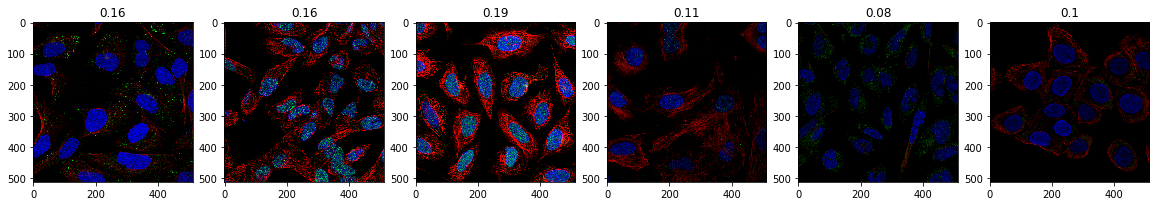

In [17]:
## generator check
td, [a,b,c,d,e]= next(train_generator)

def img_show(num = 1):
    for n in range(num):
        fig, (ax) = plt.subplots(1, BATCH_SIZE, figsize = (20, 6))
        td, [a,b,c,d,e]= next(train_generator)
        for i in range(BATCH_SIZE):
                ax[i].imshow(td[i][:,:,:3])
                ax[i].set_title(str(round(td[i].std(),2)))
        plt.show()
img_show(1)

In [18]:
if is_restart == True:
    model.load_weights(best_save_model_file)#,by_name=True)
print(is_restart, best_save_model_file)
#model.load_weights('./weights/Xception(512, 512, 4)_555_8_True_0.002_True_70_15_usemean_only512_multi_v23_addext_50p_dual_wsample_71437.h5')#,by_name=True)

True ./weights/InceptionResnetV2(512, 512, 4)_189_6_True_0.002_True_70_15_usemean_only512_multi_v23_addext_50p_dual_wsample_71437.h5


In [19]:
epochs = 20
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=validation_generator,
    validation_steps=valid_steps,
    epochs=epochs,
    verbose=2,
    callbacks=callbacks)

Epoch 1/20


 - 2902s - loss: 0.0653 - focal_o_loss: 0.0962 - soft_o_loss: 0.9106 - number_o_loss: 0.0137 - bce_o_loss: 0.0958 - merge_bce_loss: 0.0974 - focal_o_f1: 0.1857 - focal_o_acc: 0.9666 - bce_o_f1: 0.1860 - bce_o_acc: 0.9668 - merge_bce_f1: 0.1962 - merge_bce_acc: 0.9665 - val_loss: 0.0592 - val_focal_o_loss: 0.0876 - val_soft_o_loss: 0.8682 - val_number_o_loss: 0.0123 - val_bce_o_loss: 0.0875 - val_merge_bce_loss: 0.0874 - val_focal_o_f1: 0.1655 - val_focal_o_acc: 0.9693 - val_bce_o_f1: 0.1658 - val_bce_o_acc: 0.9695 - val_merge_bce_f1: 0.1634 - val_merge_bce_acc: 0.9696
Epoch 2/20


 - 2856s - loss: 0.0656 - focal_o_loss: 0.0966 - soft_o_loss: 0.9197 - number_o_loss: 0.0140 - bce_o_loss: 0.0960 - merge_bce_loss: 0.0976 - focal_o_f1: 0.1847 - focal_o_acc: 0.9664 - bce_o_f1: 0.1851 - bce_o_acc: 0.9665 - merge_bce_f1: 0.1959 - merge_bce_acc: 0.9662 - val_loss: 0.0597 - val_focal_o_loss: 0.0892 - val_soft_o_loss: 0.8582 - val_number_o_loss: 0.0116 - val_bce_o_loss: 0.0893 - val_merge_bce_loss: 0.0891 - val_focal_o_f1: 0.1672 - val_focal_o_acc: 0.9687 - val_bce_o_f1: 0.1668 - val_bce_o_acc: 0.9685 - val_merge_bce_f1: 0.1649 - val_merge_bce_acc: 0.9689
Epoch 3/20


 - 2856s - loss: 0.0646 - focal_o_loss: 0.0947 - soft_o_loss: 0.9025 - number_o_loss: 0.0137 - bce_o_loss: 0.0943 - merge_bce_loss: 0.0963 - focal_o_f1: 0.1856 - focal_o_acc: 0.9671 - bce_o_f1: 0.1862 - bce_o_acc: 0.9671 - merge_bce_f1: 0.1958 - merge_bce_acc: 0.9667 - val_loss: 0.0599 - val_focal_o_loss: 0.0886 - val_soft_o_loss: 0.8428 - val_number_o_loss: 0.0126 - val_bce_o_loss: 0.0887 - val_merge_bce_loss: 0.0889 - val_focal_o_f1: 0.1676 - val_focal_o_acc: 0.9682 - val_bce_o_f1: 0.1667 - val_bce_o_acc: 0.9680 - val_merge_bce_f1: 0.1650 - val_merge_bce_acc: 0.9680
Epoch 4/20


 - 2861s - loss: 0.0648 - focal_o_loss: 0.0955 - soft_o_loss: 0.9001 - number_o_loss: 0.0138 - bce_o_loss: 0.0948 - merge_bce_loss: 0.0966 - focal_o_f1: 0.1857 - focal_o_acc: 0.9671 - bce_o_f1: 0.1864 - bce_o_acc: 0.9672 - merge_bce_f1: 0.1963 - merge_bce_acc: 0.9669 - val_loss: 0.0601 - val_focal_o_loss: 0.0890 - val_soft_o_loss: 0.8802 - val_number_o_loss: 0.0119 - val_bce_o_loss: 0.0893 - val_merge_bce_loss: 0.0893 - val_focal_o_f1: 0.1621 - val_focal_o_acc: 0.9686 - val_bce_o_f1: 0.1609 - val_bce_o_acc: 0.9687 - val_merge_bce_f1: 0.1603 - val_merge_bce_acc: 0.9686
Epoch 5/20


 - 2862s - loss: 0.0644 - focal_o_loss: 0.0945 - soft_o_loss: 0.8939 - number_o_loss: 0.0139 - bce_o_loss: 0.0941 - merge_bce_loss: 0.0957 - focal_o_f1: 0.1863 - focal_o_acc: 0.9675 - bce_o_f1: 0.1869 - bce_o_acc: 0.9675 - merge_bce_f1: 0.1973 - merge_bce_acc: 0.9670 - val_loss: 0.0591 - val_focal_o_loss: 0.0876 - val_soft_o_loss: 0.8515 - val_number_o_loss: 0.0119 - val_bce_o_loss: 0.0873 - val_merge_bce_loss: 0.0880 - val_focal_o_f1: 0.1695 - val_focal_o_acc: 0.9693 - val_bce_o_f1: 0.1694 - val_bce_o_acc: 0.9693 - val_merge_bce_f1: 0.1659 - val_merge_bce_acc: 0.9694
Epoch 6/20


 - 2892s - loss: 0.0641 - focal_o_loss: 0.0948 - soft_o_loss: 0.8847 - number_o_loss: 0.0136 - bce_o_loss: 0.0941 - merge_bce_loss: 0.0957 - focal_o_f1: 0.1867 - focal_o_acc: 0.9671 - bce_o_f1: 0.1873 - bce_o_acc: 0.9672 - merge_bce_f1: 0.1976 - merge_bce_acc: 0.9671 - val_loss: 0.0587 - val_focal_o_loss: 0.0870 - val_soft_o_loss: 0.8463 - val_number_o_loss: 0.0121 - val_bce_o_loss: 0.0867 - val_merge_bce_loss: 0.0870 - val_focal_o_f1: 0.1669 - val_focal_o_acc: 0.9689 - val_bce_o_f1: 0.1676 - val_bce_o_acc: 0.9687 - val_merge_bce_f1: 0.1660 - val_merge_bce_acc: 0.9689
Epoch 7/20


 - 2897s - loss: 0.0640 - focal_o_loss: 0.0941 - soft_o_loss: 0.8868 - number_o_loss: 0.0137 - bce_o_loss: 0.0936 - merge_bce_loss: 0.0952 - focal_o_f1: 0.1857 - focal_o_acc: 0.9674 - bce_o_f1: 0.1868 - bce_o_acc: 0.9676 - merge_bce_f1: 0.1970 - merge_bce_acc: 0.9671 - val_loss: 0.0606 - val_focal_o_loss: 0.0887 - val_soft_o_loss: 0.8872 - val_number_o_loss: 0.0125 - val_bce_o_loss: 0.0886 - val_merge_bce_loss: 0.0899 - val_focal_o_f1: 0.1656 - val_focal_o_acc: 0.9688 - val_bce_o_f1: 0.1656 - val_bce_o_acc: 0.9690 - val_merge_bce_f1: 0.1635 - val_merge_bce_acc: 0.9684
Epoch 8/20


 - 2903s - loss: 0.0635 - focal_o_loss: 0.0937 - soft_o_loss: 0.8802 - number_o_loss: 0.0134 - bce_o_loss: 0.0934 - merge_bce_loss: 0.0948 - focal_o_f1: 0.1864 - focal_o_acc: 0.9675 - bce_o_f1: 0.1869 - bce_o_acc: 0.9675 - merge_bce_f1: 0.1967 - merge_bce_acc: 0.9673 - val_loss: 0.0580 - val_focal_o_loss: 0.0855 - val_soft_o_loss: 0.8342 - val_number_o_loss: 0.0119 - val_bce_o_loss: 0.0858 - val_merge_bce_loss: 0.0862 - val_focal_o_f1: 0.1661 - val_focal_o_acc: 0.9699 - val_bce_o_f1: 0.1664 - val_bce_o_acc: 0.9698 - val_merge_bce_f1: 0.1633 - val_merge_bce_acc: 0.9693
Epoch 9/20


 - 2904s - loss: 0.0638 - focal_o_loss: 0.0940 - soft_o_loss: 0.8902 - number_o_loss: 0.0135 - bce_o_loss: 0.0936 - merge_bce_loss: 0.0952 - focal_o_f1: 0.1864 - focal_o_acc: 0.9673 - bce_o_f1: 0.1871 - bce_o_acc: 0.9675 - merge_bce_f1: 0.1969 - merge_bce_acc: 0.9675 - val_loss: 0.0600 - val_focal_o_loss: 0.0879 - val_soft_o_loss: 0.8311 - val_number_o_loss: 0.0131 - val_bce_o_loss: 0.0875 - val_merge_bce_loss: 0.0892 - val_focal_o_f1: 0.1684 - val_focal_o_acc: 0.9691 - val_bce_o_f1: 0.1675 - val_bce_o_acc: 0.9696 - val_merge_bce_f1: 0.1661 - val_merge_bce_acc: 0.9696

Epoch 00009: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 10/20


 - 2907s - loss: 0.0633 - focal_o_loss: 0.0931 - soft_o_loss: 0.8814 - number_o_loss: 0.0134 - bce_o_loss: 0.0928 - merge_bce_loss: 0.0943 - focal_o_f1: 0.1852 - focal_o_acc: 0.9679 - bce_o_f1: 0.1856 - bce_o_acc: 0.9680 - merge_bce_f1: 0.1960 - merge_bce_acc: 0.9676 - val_loss: 0.0574 - val_focal_o_loss: 0.0845 - val_soft_o_loss: 0.8312 - val_number_o_loss: 0.0120 - val_bce_o_loss: 0.0843 - val_merge_bce_loss: 0.0850 - val_focal_o_f1: 0.1677 - val_focal_o_acc: 0.9694 - val_bce_o_f1: 0.1673 - val_bce_o_acc: 0.9700 - val_merge_bce_f1: 0.1639 - val_merge_bce_acc: 0.9705
Epoch 11/20


 - 2905s - loss: 0.0631 - focal_o_loss: 0.0927 - soft_o_loss: 0.8715 - number_o_loss: 0.0134 - bce_o_loss: 0.0926 - merge_bce_loss: 0.0941 - focal_o_f1: 0.1878 - focal_o_acc: 0.9679 - bce_o_f1: 0.1883 - bce_o_acc: 0.9678 - merge_bce_f1: 0.1981 - merge_bce_acc: 0.9675 - val_loss: 0.0589 - val_focal_o_loss: 0.0865 - val_soft_o_loss: 0.8374 - val_number_o_loss: 0.0122 - val_bce_o_loss: 0.0859 - val_merge_bce_loss: 0.0879 - val_focal_o_f1: 0.1686 - val_focal_o_acc: 0.9691 - val_bce_o_f1: 0.1688 - val_bce_o_acc: 0.9694 - val_merge_bce_f1: 0.1661 - val_merge_bce_acc: 0.9691
Epoch 12/20


 - 2915s - loss: 0.0627 - focal_o_loss: 0.0920 - soft_o_loss: 0.8820 - number_o_loss: 0.0136 - bce_o_loss: 0.0917 - merge_bce_loss: 0.0931 - focal_o_f1: 0.1865 - focal_o_acc: 0.9681 - bce_o_f1: 0.1870 - bce_o_acc: 0.9682 - merge_bce_f1: 0.1972 - merge_bce_acc: 0.9679 - val_loss: 0.0586 - val_focal_o_loss: 0.0870 - val_soft_o_loss: 0.8535 - val_number_o_loss: 0.0118 - val_bce_o_loss: 0.0865 - val_merge_bce_loss: 0.0871 - val_focal_o_f1: 0.1676 - val_focal_o_acc: 0.9697 - val_bce_o_f1: 0.1668 - val_bce_o_acc: 0.9699 - val_merge_bce_f1: 0.1653 - val_merge_bce_acc: 0.9698

Epoch 00012: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
Epoch 13/20


 - 2923s - loss: 0.0626 - focal_o_loss: 0.0920 - soft_o_loss: 0.8632 - number_o_loss: 0.0135 - bce_o_loss: 0.0914 - merge_bce_loss: 0.0934 - focal_o_f1: 0.1884 - focal_o_acc: 0.9679 - bce_o_f1: 0.1886 - bce_o_acc: 0.9681 - merge_bce_f1: 0.1986 - merge_bce_acc: 0.9678 - val_loss: 0.0594 - val_focal_o_loss: 0.0877 - val_soft_o_loss: 0.8715 - val_number_o_loss: 0.0122 - val_bce_o_loss: 0.0871 - val_merge_bce_loss: 0.0881 - val_focal_o_f1: 0.1652 - val_focal_o_acc: 0.9689 - val_bce_o_f1: 0.1653 - val_bce_o_acc: 0.9693 - val_merge_bce_f1: 0.1625 - val_merge_bce_acc: 0.9694
Epoch 14/20


 - 2927s - loss: 0.0631 - focal_o_loss: 0.0930 - soft_o_loss: 0.8780 - number_o_loss: 0.0134 - bce_o_loss: 0.0923 - merge_bce_loss: 0.0942 - focal_o_f1: 0.1872 - focal_o_acc: 0.9679 - bce_o_f1: 0.1877 - bce_o_acc: 0.9678 - merge_bce_f1: 0.1976 - merge_bce_acc: 0.9675 - val_loss: 0.0583 - val_focal_o_loss: 0.0867 - val_soft_o_loss: 0.8342 - val_number_o_loss: 0.0119 - val_bce_o_loss: 0.0864 - val_merge_bce_loss: 0.0867 - val_focal_o_f1: 0.1688 - val_focal_o_acc: 0.9694 - val_bce_o_f1: 0.1684 - val_bce_o_acc: 0.9697 - val_merge_bce_f1: 0.1672 - val_merge_bce_acc: 0.9694
Epoch 15/20


 - 2924s - loss: 0.0627 - focal_o_loss: 0.0924 - soft_o_loss: 0.8742 - number_o_loss: 0.0133 - bce_o_loss: 0.0919 - merge_bce_loss: 0.0935 - focal_o_f1: 0.1869 - focal_o_acc: 0.9679 - bce_o_f1: 0.1873 - bce_o_acc: 0.9682 - merge_bce_f1: 0.1974 - merge_bce_acc: 0.9677 - val_loss: 0.0579 - val_focal_o_loss: 0.0852 - val_soft_o_loss: 0.8365 - val_number_o_loss: 0.0124 - val_bce_o_loss: 0.0855 - val_merge_bce_loss: 0.0855 - val_focal_o_f1: 0.1685 - val_focal_o_acc: 0.9696 - val_bce_o_f1: 0.1683 - val_bce_o_acc: 0.9693 - val_merge_bce_f1: 0.1660 - val_merge_bce_acc: 0.9692
Epoch 16/20


 - 2895s - loss: 0.0628 - focal_o_loss: 0.0920 - soft_o_loss: 0.8789 - number_o_loss: 0.0134 - bce_o_loss: 0.0920 - merge_bce_loss: 0.0935 - focal_o_f1: 0.1871 - focal_o_acc: 0.9678 - bce_o_f1: 0.1869 - bce_o_acc: 0.9678 - merge_bce_f1: 0.1977 - merge_bce_acc: 0.9678 - val_loss: 0.0588 - val_focal_o_loss: 0.0878 - val_soft_o_loss: 0.8303 - val_number_o_loss: 0.0120 - val_bce_o_loss: 0.0875 - val_merge_bce_loss: 0.0874 - val_focal_o_f1: 0.1662 - val_focal_o_acc: 0.9694 - val_bce_o_f1: 0.1658 - val_bce_o_acc: 0.9696 - val_merge_bce_f1: 0.1647 - val_merge_bce_acc: 0.9698
Epoch 17/20


 - 2900s - loss: 0.0627 - focal_o_loss: 0.0927 - soft_o_loss: 0.8673 - number_o_loss: 0.0133 - bce_o_loss: 0.0918 - merge_bce_loss: 0.0935 - focal_o_f1: 0.1865 - focal_o_acc: 0.9679 - bce_o_f1: 0.1873 - bce_o_acc: 0.9680 - merge_bce_f1: 0.1976 - merge_bce_acc: 0.9678 - val_loss: 0.0596 - val_focal_o_loss: 0.0883 - val_soft_o_loss: 0.8555 - val_number_o_loss: 0.0125 - val_bce_o_loss: 0.0878 - val_merge_bce_loss: 0.0882 - val_focal_o_f1: 0.1709 - val_focal_o_acc: 0.9686 - val_bce_o_f1: 0.1713 - val_bce_o_acc: 0.9687 - val_merge_bce_f1: 0.1686 - val_merge_bce_acc: 0.9692
Epoch 18/20


 - 2898s - loss: 0.0626 - focal_o_loss: 0.0922 - soft_o_loss: 0.8690 - number_o_loss: 0.0134 - bce_o_loss: 0.0918 - merge_bce_loss: 0.0932 - focal_o_f1: 0.1875 - focal_o_acc: 0.9680 - bce_o_f1: 0.1877 - bce_o_acc: 0.9681 - merge_bce_f1: 0.1982 - merge_bce_acc: 0.9680 - val_loss: 0.0577 - val_focal_o_loss: 0.0848 - val_soft_o_loss: 0.8267 - val_number_o_loss: 0.0120 - val_bce_o_loss: 0.0844 - val_merge_bce_loss: 0.0858 - val_focal_o_f1: 0.1653 - val_focal_o_acc: 0.9695 - val_bce_o_f1: 0.1651 - val_bce_o_acc: 0.9698 - val_merge_bce_f1: 0.1639 - val_merge_bce_acc: 0.9700
Epoch 19/20


 - 2900s - loss: 0.0626 - focal_o_loss: 0.0924 - soft_o_loss: 0.8708 - number_o_loss: 0.0133 - bce_o_loss: 0.0918 - merge_bce_loss: 0.0932 - focal_o_f1: 0.1877 - focal_o_acc: 0.9680 - bce_o_f1: 0.1885 - bce_o_acc: 0.9682 - merge_bce_f1: 0.1988 - merge_bce_acc: 0.9678 - val_loss: 0.0590 - val_focal_o_loss: 0.0875 - val_soft_o_loss: 0.8532 - val_number_o_loss: 0.0122 - val_bce_o_loss: 0.0869 - val_merge_bce_loss: 0.0875 - val_focal_o_f1: 0.1642 - val_focal_o_acc: 0.9694 - val_bce_o_f1: 0.1653 - val_bce_o_acc: 0.9697 - val_merge_bce_f1: 0.1632 - val_merge_bce_acc: 0.9698
Epoch 20/20


 - 2916s - loss: 0.0629 - focal_o_loss: 0.0923 - soft_o_loss: 0.8724 - number_o_loss: 0.0134 - bce_o_loss: 0.0922 - merge_bce_loss: 0.0938 - focal_o_f1: 0.1873 - focal_o_acc: 0.9677 - bce_o_f1: 0.1877 - bce_o_acc: 0.9677 - merge_bce_f1: 0.1980 - merge_bce_acc: 0.9676 - val_loss: 0.0587 - val_focal_o_loss: 0.0867 - val_soft_o_loss: 0.8535 - val_number_o_loss: 0.0120 - val_bce_o_loss: 0.0862 - val_merge_bce_loss: 0.0873 - val_focal_o_f1: 0.1669 - val_focal_o_acc: 0.9688 - val_bce_o_f1: 0.1663 - val_bce_o_acc: 0.9691 - val_merge_bce_f1: 0.1654 - val_merge_bce_acc: 0.9690

Epoch 00020: ReduceLROnPlateau reducing learning rate to 1.9999999949504855e-07.



In [19]:
train_generator =None
validation_generator = None
import gc
gc.collect()

#model.load_weights(best_save_model_file)
total_layers_num = len(model.layers)
trainable_last = total_layers_num - FINE_LAYER
for idx in range(len(model.layers)):
    if idx < trainable_last:
        model.layers[idx].trainable = False
    else:
        model.layers[idx].trainable = True
        
#lastfc_loss: 3.9273 - lastfc_softmax_loss: 0.5784 
#- last_number_loss: 0.0106 - lastfc_bce_loss: 0.0609 
#- lastfc_f1_loss: 0.7575, merge_bce: .0609 

OPT = SGD(lr=0.001,momentum=0.9)
losses = {'focal_o':binary_crossentropy , 'soft_o':categorical_crossentropy
          , 'number_o':mean_squared_error , 'bce_o':binary_crossentropy
          ,'merge_bce':f1_loss}
         #,'lastfc_v14_f1':f1_loss, 'merge_bce':binary_crossentropy}
lossWeights = [1.0/0.06
               ,1.0/0.58
               ,1.0/0.01
               ,1.0/0.06
               #,1.0/0.75
              ,5.0/0.75]#0.06]
lossWeights=lossWeights/np.sum(lossWeights)
lossWeights=lossWeights.tolist()
metrics1 = {'focal_o':[f1,'acc'],'bce_o':[f1,'acc'],  'merge_bce':[f1,'acc']}#  'lastfc_v14_f1':[f1,'acc'],  'merge_bce':[f1,'acc']}
model.compile(optimizer=OPT, loss=losses ,loss_weights=lossWeights, metrics=metrics1)

fine_batch = BATCH_SIZE*FINE_BATCH_MUL
train_steps = len(train_set)//fine_batch
valid_steps = len(val_set)//fine_batch

train_generator = data_generator.create_train_gen(train_set, add_dataset_info, fine_batch, SHAPE, augument=True, mean= mean_arr)
validation_generator = data_generator.create_valid_gen(val_set, fine_batch, SHAPE, augument=False, mean= mean_arr)

epochs = 100
hist1 = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=validation_generator,
    validation_steps=valid_steps,
    epochs=epochs,
    verbose=2,
    callbacks=callbacks)

Epoch 1/100


 - 1727s - loss: 0.0657 - focal_o_loss: 0.0936 - soft_o_loss: 0.8912 - number_o_loss: 0.0138 - bce_o_loss: 0.0929 - merge_bce_loss: 0.4930 - focal_o_f1: 0.4446 - focal_o_acc: 0.9677 - bce_o_f1: 0.4476 - bce_o_acc: 0.9680 - merge_bce_f1: 0.4571 - merge_bce_acc: 0.6111 - val_loss: 0.0694 - val_focal_o_loss: 0.0860 - val_soft_o_loss: 0.8694 - val_number_o_loss: 0.0124 - val_bce_o_loss: 0.0857 - val_merge_bce_loss: 0.6352 - val_focal_o_f1: 0.3644 - val_focal_o_acc: 0.9703 - val_bce_o_f1: 0.3648 - val_bce_o_acc: 0.9701 - val_merge_bce_f1: 0.3377 - val_merge_bce_acc: 0.6131
Epoch 2/100


 - 1608s - loss: 0.0653 - focal_o_loss: 0.0931 - soft_o_loss: 0.8846 - number_o_loss: 0.0139 - bce_o_loss: 0.0929 - merge_bce_loss: 0.4861 - focal_o_f1: 0.4480 - focal_o_acc: 0.9682 - bce_o_f1: 0.4503 - bce_o_acc: 0.9682 - merge_bce_f1: 0.4631 - merge_bce_acc: 0.6110 - val_loss: 0.0695 - val_focal_o_loss: 0.0889 - val_soft_o_loss: 0.8463 - val_number_o_loss: 0.0126 - val_bce_o_loss: 0.0883 - val_merge_bce_loss: 0.6273 - val_focal_o_f1: 0.3705 - val_focal_o_acc: 0.9687 - val_bce_o_f1: 0.3715 - val_bce_o_acc: 0.9689 - val_merge_bce_f1: 0.3474 - val_merge_bce_acc: 0.6157
Epoch 3/100


 - 1566s - loss: 0.0654 - focal_o_loss: 0.0932 - soft_o_loss: 0.8840 - number_o_loss: 0.0140 - bce_o_loss: 0.0926 - merge_bce_loss: 0.4861 - focal_o_f1: 0.4498 - focal_o_acc: 0.9680 - bce_o_f1: 0.4514 - bce_o_acc: 0.9681 - merge_bce_f1: 0.4682 - merge_bce_acc: 0.6097 - val_loss: 0.0692 - val_focal_o_loss: 0.0887 - val_soft_o_loss: 0.8410 - val_number_o_loss: 0.0121 - val_bce_o_loss: 0.0885 - val_merge_bce_loss: 0.6293 - val_focal_o_f1: 0.3618 - val_focal_o_acc: 0.9685 - val_bce_o_f1: 0.3626 - val_bce_o_acc: 0.9683 - val_merge_bce_f1: 0.3423 - val_merge_bce_acc: 0.6000
Epoch 4/100


 - 1541s - loss: 0.0654 - focal_o_loss: 0.0930 - soft_o_loss: 0.8852 - number_o_loss: 0.0141 - bce_o_loss: 0.0926 - merge_bce_loss: 0.4859 - focal_o_f1: 0.4478 - focal_o_acc: 0.9682 - bce_o_f1: 0.4522 - bce_o_acc: 0.9684 - merge_bce_f1: 0.4711 - merge_bce_acc: 0.6148 - val_loss: 0.0680 - val_focal_o_loss: 0.0848 - val_soft_o_loss: 0.8332 - val_number_o_loss: 0.0120 - val_bce_o_loss: 0.0844 - val_merge_bce_loss: 0.6272 - val_focal_o_f1: 0.3688 - val_focal_o_acc: 0.9700 - val_bce_o_f1: 0.3689 - val_bce_o_acc: 0.9698 - val_merge_bce_f1: 0.3518 - val_merge_bce_acc: 0.6219
Epoch 5/100


 - 1529s - loss: 0.0657 - focal_o_loss: 0.0937 - soft_o_loss: 0.9007 - number_o_loss: 0.0141 - bce_o_loss: 0.0933 - merge_bce_loss: 0.4855 - focal_o_f1: 0.4488 - focal_o_acc: 0.9679 - bce_o_f1: 0.4504 - bce_o_acc: 0.9682 - merge_bce_f1: 0.4747 - merge_bce_acc: 0.6086 - val_loss: 0.0690 - val_focal_o_loss: 0.0858 - val_soft_o_loss: 0.8806 - val_number_o_loss: 0.0115 - val_bce_o_loss: 0.0856 - val_merge_bce_loss: 0.6384 - val_focal_o_f1: 0.3501 - val_focal_o_acc: 0.9697 - val_bce_o_f1: 0.3542 - val_bce_o_acc: 0.9698 - val_merge_bce_f1: 0.3382 - val_merge_bce_acc: 0.6212
Epoch 6/100


 - 1579s - loss: 0.0656 - focal_o_loss: 0.0937 - soft_o_loss: 0.8978 - number_o_loss: 0.0141 - bce_o_loss: 0.0929 - merge_bce_loss: 0.4846 - focal_o_f1: 0.4481 - focal_o_acc: 0.9679 - bce_o_f1: 0.4487 - bce_o_acc: 0.9684 - merge_bce_f1: 0.4770 - merge_bce_acc: 0.6142 - val_loss: 0.0673 - val_focal_o_loss: 0.0842 - val_soft_o_loss: 0.8273 - val_number_o_loss: 0.0115 - val_bce_o_loss: 0.0836 - val_merge_bce_loss: 0.6251 - val_focal_o_f1: 0.3676 - val_focal_o_acc: 0.9709 - val_bce_o_f1: 0.3649 - val_bce_o_acc: 0.9708 - val_merge_bce_f1: 0.3520 - val_merge_bce_acc: 0.6160
Epoch 7/100


 - 1560s - loss: 0.0653 - focal_o_loss: 0.0931 - soft_o_loss: 0.8855 - number_o_loss: 0.0141 - bce_o_loss: 0.0927 - merge_bce_loss: 0.4837 - focal_o_f1: 0.4473 - focal_o_acc: 0.9681 - bce_o_f1: 0.4499 - bce_o_acc: 0.9680 - merge_bce_f1: 0.4798 - merge_bce_acc: 0.6108 - val_loss: 0.0679 - val_focal_o_loss: 0.0850 - val_soft_o_loss: 0.8317 - val_number_o_loss: 0.0120 - val_bce_o_loss: 0.0850 - val_merge_bce_loss: 0.6231 - val_focal_o_f1: 0.3662 - val_focal_o_acc: 0.9700 - val_bce_o_f1: 0.3646 - val_bce_o_acc: 0.9697 - val_merge_bce_f1: 0.3526 - val_merge_bce_acc: 0.6183
Epoch 8/100


 - 1539s - loss: 0.0651 - focal_o_loss: 0.0930 - soft_o_loss: 0.8914 - number_o_loss: 0.0139 - bce_o_loss: 0.0926 - merge_bce_loss: 0.4810 - focal_o_f1: 0.4489 - focal_o_acc: 0.9680 - bce_o_f1: 0.4511 - bce_o_acc: 0.9679 - merge_bce_f1: 0.4834 - merge_bce_acc: 0.6121 - val_loss: 0.0684 - val_focal_o_loss: 0.0864 - val_soft_o_loss: 0.8535 - val_number_o_loss: 0.0118 - val_bce_o_loss: 0.0863 - val_merge_bce_loss: 0.6246 - val_focal_o_f1: 0.3697 - val_focal_o_acc: 0.9696 - val_bce_o_f1: 0.3693 - val_bce_o_acc: 0.9695 - val_merge_bce_f1: 0.3572 - val_merge_bce_acc: 0.6007
Epoch 9/100


 - 1532s - loss: 0.0657 - focal_o_loss: 0.0944 - soft_o_loss: 0.8979 - number_o_loss: 0.0139 - bce_o_loss: 0.0937 - merge_bce_loss: 0.4858 - focal_o_f1: 0.4457 - focal_o_acc: 0.9678 - bce_o_f1: 0.4481 - bce_o_acc: 0.9679 - merge_bce_f1: 0.4839 - merge_bce_acc: 0.6096 - val_loss: 0.0665 - val_focal_o_loss: 0.0828 - val_soft_o_loss: 0.8092 - val_number_o_loss: 0.0117 - val_bce_o_loss: 0.0825 - val_merge_bce_loss: 0.6154 - val_focal_o_f1: 0.3752 - val_focal_o_acc: 0.9706 - val_bce_o_f1: 0.3758 - val_bce_o_acc: 0.9703 - val_merge_bce_f1: 0.3594 - val_merge_bce_acc: 0.6379
Epoch 10/100


 - 1538s - loss: 0.0659 - focal_o_loss: 0.0950 - soft_o_loss: 0.8913 - number_o_loss: 0.0142 - bce_o_loss: 0.0947 - merge_bce_loss: 0.4829 - focal_o_f1: 0.4452 - focal_o_acc: 0.9678 - bce_o_f1: 0.4482 - bce_o_acc: 0.9678 - merge_bce_f1: 0.4863 - merge_bce_acc: 0.6081 - val_loss: 0.0692 - val_focal_o_loss: 0.0886 - val_soft_o_loss: 0.8528 - val_number_o_loss: 0.0120 - val_bce_o_loss: 0.0883 - val_merge_bce_loss: 0.6284 - val_focal_o_f1: 0.3633 - val_focal_o_acc: 0.9688 - val_bce_o_f1: 0.3610 - val_bce_o_acc: 0.9684 - val_merge_bce_f1: 0.3512 - val_merge_bce_acc: 0.6121
Epoch 11/100


 - 1529s - loss: 0.0654 - focal_o_loss: 0.0938 - soft_o_loss: 0.8980 - number_o_loss: 0.0140 - bce_o_loss: 0.0931 - merge_bce_loss: 0.4806 - focal_o_f1: 0.4477 - focal_o_acc: 0.9680 - bce_o_f1: 0.4495 - bce_o_acc: 0.9683 - merge_bce_f1: 0.4891 - merge_bce_acc: 0.6117 - val_loss: 0.0700 - val_focal_o_loss: 0.0888 - val_soft_o_loss: 0.8817 - val_number_o_loss: 0.0123 - val_bce_o_loss: 0.0886 - val_merge_bce_loss: 0.6316 - val_focal_o_f1: 0.3591 - val_focal_o_acc: 0.9678 - val_bce_o_f1: 0.3604 - val_bce_o_acc: 0.9680 - val_merge_bce_f1: 0.3537 - val_merge_bce_acc: 0.6088
Epoch 12/100


 - 1525s - loss: 0.0651 - focal_o_loss: 0.0940 - soft_o_loss: 0.8867 - number_o_loss: 0.0139 - bce_o_loss: 0.0933 - merge_bce_loss: 0.4774 - focal_o_f1: 0.4504 - focal_o_acc: 0.9677 - bce_o_f1: 0.4532 - bce_o_acc: 0.9681 - merge_bce_f1: 0.4953 - merge_bce_acc: 0.6093 - val_loss: 0.0683 - val_focal_o_loss: 0.0880 - val_soft_o_loss: 0.7968 - val_number_o_loss: 0.0122 - val_bce_o_loss: 0.0878 - val_merge_bce_loss: 0.6227 - val_focal_o_f1: 0.3666 - val_focal_o_acc: 0.9689 - val_bce_o_f1: 0.3655 - val_bce_o_acc: 0.9690 - val_merge_bce_f1: 0.3577 - val_merge_bce_acc: 0.6497

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 13/100


 - 1522s - loss: 0.0649 - focal_o_loss: 0.0930 - soft_o_loss: 0.8942 - number_o_loss: 0.0140 - bce_o_loss: 0.0926 - merge_bce_loss: 0.4758 - focal_o_f1: 0.4492 - focal_o_acc: 0.9682 - bce_o_f1: 0.4522 - bce_o_acc: 0.9683 - merge_bce_f1: 0.4968 - merge_bce_acc: 0.6094 - val_loss: 0.0674 - val_focal_o_loss: 0.0856 - val_soft_o_loss: 0.8296 - val_number_o_loss: 0.0117 - val_bce_o_loss: 0.0851 - val_merge_bce_loss: 0.6153 - val_focal_o_f1: 0.3721 - val_focal_o_acc: 0.9698 - val_bce_o_f1: 0.3716 - val_bce_o_acc: 0.9694 - val_merge_bce_f1: 0.3663 - val_merge_bce_acc: 0.6235
Epoch 14/100


 - 1522s - loss: 0.0653 - focal_o_loss: 0.0938 - soft_o_loss: 0.9006 - number_o_loss: 0.0141 - bce_o_loss: 0.0934 - merge_bce_loss: 0.4767 - focal_o_f1: 0.4482 - focal_o_acc: 0.9679 - bce_o_f1: 0.4513 - bce_o_acc: 0.9679 - merge_bce_f1: 0.4959 - merge_bce_acc: 0.6113 - val_loss: 0.0676 - val_focal_o_loss: 0.0864 - val_soft_o_loss: 0.8188 - val_number_o_loss: 0.0118 - val_bce_o_loss: 0.0856 - val_merge_bce_loss: 0.6174 - val_focal_o_f1: 0.3682 - val_focal_o_acc: 0.9702 - val_bce_o_f1: 0.3682 - val_bce_o_acc: 0.9699 - val_merge_bce_f1: 0.3654 - val_merge_bce_acc: 0.6317
Epoch 15/100


 - 1515s - loss: 0.0654 - focal_o_loss: 0.0939 - soft_o_loss: 0.8900 - number_o_loss: 0.0143 - bce_o_loss: 0.0935 - merge_bce_loss: 0.4777 - focal_o_f1: 0.4483 - focal_o_acc: 0.9678 - bce_o_f1: 0.4511 - bce_o_acc: 0.9679 - merge_bce_f1: 0.4957 - merge_bce_acc: 0.6057 - val_loss: 0.0681 - val_focal_o_loss: 0.0869 - val_soft_o_loss: 0.8493 - val_number_o_loss: 0.0115 - val_bce_o_loss: 0.0868 - val_merge_bce_loss: 0.6218 - val_focal_o_f1: 0.3694 - val_focal_o_acc: 0.9688 - val_bce_o_f1: 0.3663 - val_bce_o_acc: 0.9691 - val_merge_bce_f1: 0.3602 - val_merge_bce_acc: 0.6157
Epoch 16/100


 - 1510s - loss: 0.0650 - focal_o_loss: 0.0934 - soft_o_loss: 0.8924 - number_o_loss: 0.0141 - bce_o_loss: 0.0930 - merge_bce_loss: 0.4736 - focal_o_f1: 0.4505 - focal_o_acc: 0.9680 - bce_o_f1: 0.4538 - bce_o_acc: 0.9682 - merge_bce_f1: 0.4971 - merge_bce_acc: 0.6117 - val_loss: 0.0675 - val_focal_o_loss: 0.0873 - val_soft_o_loss: 0.8263 - val_number_o_loss: 0.0111 - val_bce_o_loss: 0.0866 - val_merge_bce_loss: 0.6205 - val_focal_o_f1: 0.3702 - val_focal_o_acc: 0.9685 - val_bce_o_f1: 0.3719 - val_bce_o_acc: 0.9685 - val_merge_bce_f1: 0.3651 - val_merge_bce_acc: 0.6206

Epoch 00016: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 17/100


 - 1516s - loss: 0.0650 - focal_o_loss: 0.0934 - soft_o_loss: 0.8944 - number_o_loss: 0.0139 - bce_o_loss: 0.0931 - merge_bce_loss: 0.4751 - focal_o_f1: 0.4498 - focal_o_acc: 0.9680 - bce_o_f1: 0.4507 - bce_o_acc: 0.9681 - merge_bce_f1: 0.4951 - merge_bce_acc: 0.6147 - val_loss: 0.0683 - val_focal_o_loss: 0.0866 - val_soft_o_loss: 0.8581 - val_number_o_loss: 0.0119 - val_bce_o_loss: 0.0863 - val_merge_bce_loss: 0.6178 - val_focal_o_f1: 0.3703 - val_focal_o_acc: 0.9695 - val_bce_o_f1: 0.3653 - val_bce_o_acc: 0.9691 - val_merge_bce_f1: 0.3621 - val_merge_bce_acc: 0.6121
Epoch 18/100


 - 1514s - loss: 0.0646 - focal_o_loss: 0.0927 - soft_o_loss: 0.8867 - number_o_loss: 0.0138 - bce_o_loss: 0.0923 - merge_bce_loss: 0.4744 - focal_o_f1: 0.4496 - focal_o_acc: 0.9684 - bce_o_f1: 0.4525 - bce_o_acc: 0.9684 - merge_bce_f1: 0.4985 - merge_bce_acc: 0.6113 - val_loss: 0.0687 - val_focal_o_loss: 0.0867 - val_soft_o_loss: 0.8672 - val_number_o_loss: 0.0121 - val_bce_o_loss: 0.0864 - val_merge_bce_loss: 0.6230 - val_focal_o_f1: 0.3738 - val_focal_o_acc: 0.9693 - val_bce_o_f1: 0.3739 - val_bce_o_acc: 0.9689 - val_merge_bce_f1: 0.3661 - val_merge_bce_acc: 0.6092
Epoch 19/100


 - 1508s - loss: 0.0648 - focal_o_loss: 0.0935 - soft_o_loss: 0.8903 - number_o_loss: 0.0139 - bce_o_loss: 0.0929 - merge_bce_loss: 0.4743 - focal_o_f1: 0.4481 - focal_o_acc: 0.9683 - bce_o_f1: 0.4498 - bce_o_acc: 0.9683 - merge_bce_f1: 0.4947 - merge_bce_acc: 0.6132 - val_loss: 0.0681 - val_focal_o_loss: 0.0859 - val_soft_o_loss: 0.8460 - val_number_o_loss: 0.0120 - val_bce_o_loss: 0.0856 - val_merge_bce_loss: 0.6201 - val_focal_o_f1: 0.3730 - val_focal_o_acc: 0.9692 - val_bce_o_f1: 0.3683 - val_bce_o_acc: 0.9693 - val_merge_bce_f1: 0.3646 - val_merge_bce_acc: 0.6235

Epoch 00019: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 20/100


 - 1507s - loss: 0.0654 - focal_o_loss: 0.0945 - soft_o_loss: 0.8894 - number_o_loss: 0.0140 - bce_o_loss: 0.0940 - merge_bce_loss: 0.4780 - focal_o_f1: 0.4506 - focal_o_acc: 0.9677 - bce_o_f1: 0.4508 - bce_o_acc: 0.9677 - merge_bce_f1: 0.4964 - merge_bce_acc: 0.6059 - val_loss: 0.0681 - val_focal_o_loss: 0.0852 - val_soft_o_loss: 0.8348 - val_number_o_loss: 0.0122 - val_bce_o_loss: 0.0849 - val_merge_bce_loss: 0.6229 - val_focal_o_f1: 0.3689 - val_focal_o_acc: 0.9704 - val_bce_o_f1: 0.3664 - val_bce_o_acc: 0.9699 - val_merge_bce_f1: 0.3646 - val_merge_bce_acc: 0.6343
Epoch 00020: early stopping



In [20]:
best_epoch = np.argmax(hist1.history['val_merge_bce_f1']).astype(int)
best_top3_score = str(int(np.round(hist1.history['val_merge_bce_f1'][best_epoch]*10000,0)))

sub_prefix = model_name+'_'+ str(best_epoch)+'epoch'+'_f1_'+best_top3_score + '_' + str(TTA)
probs_file_path = './probs/' + sub_prefix+ '.npy'
sub_file_path = './subs/' + sub_prefix+ '.csv'
hist_file_path = './hists/' + sub_prefix + '.png'
print(sub_prefix)

InceptionResnetV2(512, 512, 4)_189_6_True_0.002_True_70_15_usemean_only512_multi_v23_addext_50p_dual_wsample_71437_12epoch_f1_3663_8


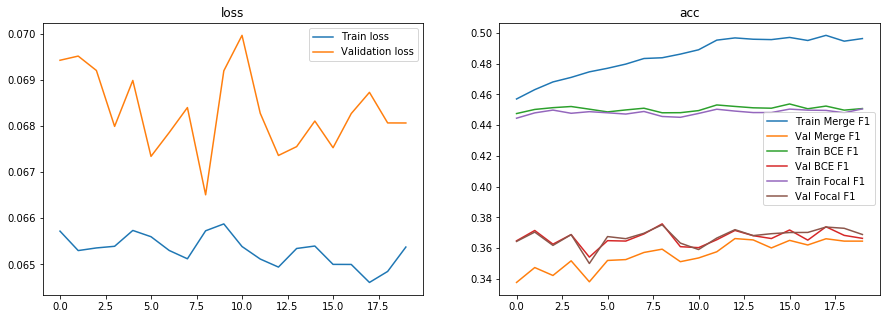

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('loss')
ax[0].plot(hist1.epoch, hist1.history["loss"], label="Train loss")
ax[0].plot(hist1.epoch, hist1.history["val_loss"], label="Validation loss")
ax[1].set_title('acc')
ax[1].plot(hist1.epoch, hist1.history["merge_bce_f1"], label="Train Merge F1")
ax[1].plot(hist1.epoch, hist1.history["val_merge_bce_f1"], label="Val Merge F1")
ax[1].plot(hist1.epoch, hist1.history["bce_o_f1"], label="Train BCE F1")
ax[1].plot(hist1.epoch, hist1.history["val_bce_o_f1"], label="Val BCE F1")
ax[1].plot(hist1.epoch, hist1.history["focal_o_f1"], label="Train Focal F1")
ax[1].plot(hist1.epoch, hist1.history["val_focal_o_f1"], label="Val Focal F1")
ax[0].legend()
ax[1].legend()

# Full validation
Perform validation on full validation dataset. Choose appropriate prediction threshold maximalizing the validation F1-score.

In [22]:
model.load_weights(best_save_model_file)

In [23]:
fullValGen = val_set
img = data_generator.load_image(val_set[0]['path'])
img.shape

(512, 512, 4)

In [24]:
def get_tta_image(image, tta):
    images=[]
    temp = image
    images.append(temp)
    
    if tta == 8:
        for i in range(3):
            temp = np.rot90(temp)
            images.append(temp)

        for i in range(len(images)):
            images.append(np.fliplr(images[i])) 
    
    npimage = np.concatenate([images])
    return npimage

def predict_tta(model,image, tta = 8):
    tta_image = get_tta_image(image, tta)
    focal,soft, number,bce,merge = model.predict(tta_image)
    avg = (focal+bce + merge)/3.0#+f1)/3.0
    avg = np.average(avg, axis = 0).reshape(1,28)
    focal = np.average(focal, axis = 0).reshape(1,28)
    bce = np.average(bce, axis = 0).reshape(1,28)
    merge = np.average(merge, axis = 0).reshape(1,28)
    soft = np.average(soft, axis = 0).reshape(1,29)
    number = np.average(number, axis = 0).reshape(1,1)
    return avg,focal,bce,merge,soft,number

In [25]:
lastFullValPred_avg = np.empty((0, 28))
lastFullValPred_focal = np.empty((0, 28))
lastFullValPred_bce = np.empty((0, 28))
lastFullValPred_merge = np.empty((0, 28))
lastFullValPred_soft = np.empty((0, 29))
lastFullValPred_number = np.empty((0, 1))


lastFullValLabels = np.empty((0, 28))
for i in tqdm_notebook(range(len(val_set))): 
    path = val_set[i]['path']
    lbl = np.zeros(28)
    lbl[val_set[i]['labels']] = 1
    im = data_generator.load_image(path)
    if mean_arr is not None:
        im = im.astype(np.float32) -mean_arr
        im /= 255.0
    avg,focal,bce,merge,soft,number = predict_tta(model,im, tta = TTA)
    lbl = lbl.reshape(1,28)
    lastFullValPred_avg = np.append(lastFullValPred_avg, avg, axis=0)
    lastFullValPred_focal = np.append(lastFullValPred_focal, focal, axis=0)
    lastFullValPred_bce = np.append(lastFullValPred_bce, bce, axis=0)
    lastFullValPred_merge = np.append(lastFullValPred_merge, merge, axis=0)
    lastFullValPred_soft = np.append(lastFullValPred_soft, soft , axis=0)    
    lastFullValPred_number = np.append(lastFullValPred_number, number, axis=0)
    lastFullValLabels = np.append(lastFullValLabels, lbl, axis=0)
print(lastFullValPred_avg.shape, lastFullValLabels.shape)


(3080, 28) (3080, 28)


In [26]:
import scipy.optimize as scopt
from sklearn.metrics import f1_score
thresholds = np.linspace(0, 1, 1000)
score = 0.0
test_threshold=0.5*np.ones(28)
best_threshold=np.zeros(28)
best_val = np.zeros(28)
for i in range(28):
    for threshold in thresholds:
        test_threshold[i] = threshold
        val_predict = (lastFullValPred_merge > test_threshold)
        score = f1_score(lastFullValLabels, val_predict, average='macro')
        if score > best_val[i]:
            best_threshold[i] = threshold
            best_val[i] = score

    print("Threshold[%d] %0.6f, F1: %0.6f" % (i,best_threshold[i],best_val[i]))
    test_threshold[i] = best_threshold[i]

print("Best threshold: ")
print(best_threshold)
print("Best f1:")
print(best_val)


def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))
def F1_soft(preds,targs,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score
def fit_val(x,y):
    params = 0.5*np.ones(28)
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*(p - 0.5)), axis=None)
    p, success = scopt.leastsq(error, params)
    return p
pred,y = lastFullValPred_merge, lastFullValLabels

th = fit_val(pred,y)
th[th<0.1] = 0.1
best_threshold[best_threshold<0.1]=0.1
print('Thresholds: ',th)
print('Best Thresholds: ',best_threshold)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 macro (th = 0.5): ',f1_score(y, pred>0.5, average='macro'))
print('F1 macro: ',f1_score(y, pred>best_threshold, average='macro'))

Threshold[0] 0.452452, F1: 0.602019
Threshold[1] 0.321321, F1: 0.602852
Threshold[2] 0.304304, F1: 0.603165
Threshold[3] 0.377377, F1: 0.603767
Threshold[4] 0.324324, F1: 0.604965
Threshold[5] 0.276276, F1: 0.606038
Threshold[6] 0.254254, F1: 0.606989
Threshold[7] 0.423423, F1: 0.607497
Threshold[8] 0.142142, F1: 0.607997
Threshold[9] 0.489489, F1: 0.607997
Threshold[10] 0.081081, F1: 0.616925
Threshold[11] 0.151151, F1: 0.619742
Threshold[12] 0.321321, F1: 0.620687
Threshold[13] 0.487487, F1: 0.620687
Threshold[14] 0.699700, F1: 0.620949
Threshold[15] 0.861862, F1: 0.632854
Threshold[16] 0.408408, F1: 0.635859
Threshold[17] 0.427427, F1: 0.637900
Threshold[18] 0.229229, F1: 0.642833
Threshold[19] 0.165165, F1: 0.646043
Threshold[20] 0.524525, F1: 0.647534
Threshold[21] 0.353353, F1: 0.648721
Threshold[22] 0.240240, F1: 0.651252
Threshold[23] 0.320320, F1: 0.652192
Threshold[24] 0.567568, F1: 0.652889
Threshold[25] 0.424424, F1: 0.654345
Threshold[26] 0.423423, F1: 0.655757
Threshold[2

In [27]:
from sklearn.metrics import f1_score as off1

def cal_val_f1_score(lastFullValPred,  discript):
    rng = np.arange(0.4, 0.6, 0.001)
    f1s = np.zeros((rng.shape[0], 28))
    for j,t in enumerate(tqdm_notebook(rng)):
        for i in range(28):
            p = np.array(lastFullValPred[:,i]>t, dtype=np.int8)
            scoref1 = off1(lastFullValLabels[:,i], p, average='binary')
            f1s[j,i] = scoref1
    print(discript,'Individual F1-scores for each class:')
    print(np.max(f1s, axis=0))
    print(discript , 'Macro F1-score CV =', np.mean(np.max(f1s, axis=0)))
    plt.plot(rng, f1s)
    plt.show()
    T = np.empty(28)
    for i in range(28):
        T[i] = rng[np.where(f1s[:,i] == np.max(f1s[:,i]))[0][0]]
    print('Probability threshold maximizing CV F1-score for each class:')
    print(T)
    return T
    #return f1s


AVG Individual F1-scores for each class:
[0.85193622 0.83257919 0.77329193 0.68461538 0.72611465 0.65411765
 0.53061224 0.78383838 0.90909091 0.5        0.         0.63291139
 0.57692308 0.56097561 0.88695652 0.66666667 0.325      0.4375
 0.36206897 0.60251046 0.4        0.62623413 0.49122807 0.79847909
 0.72972973 0.6762142  0.61538462 0.66666667]
AVG Macro F1-score CV = 0.6179159193163748


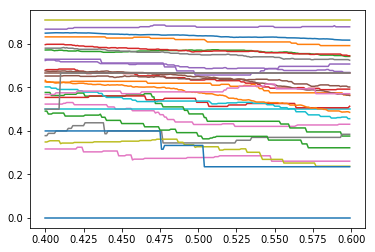

Probability threshold maximizing CV F1-score for each class:
[0.419 0.4   0.509 0.409 0.401 0.412 0.414 0.412 0.4   0.4   0.4   0.4
 0.4   0.429 0.471 0.4   0.421 0.426 0.473 0.4   0.4   0.4   0.4   0.401
 0.4   0.4   0.544 0.41 ]



FOCAL Individual F1-scores for each class:
[0.85183782 0.82191781 0.77177177 0.66666667 0.72611465 0.64439141
 0.5170068  0.76446281 0.90909091 0.5        0.         0.62420382
 0.54545455 0.56097561 0.89565217 0.66666667 0.31578947 0.46666667
 0.32142857 0.5907173  0.33333333 0.6084425  0.44444444 0.79467681
 0.6969697  0.67850349 0.57971014 0.66666667]
FOCAL Macro F1-score CV = 0.6058415198586112


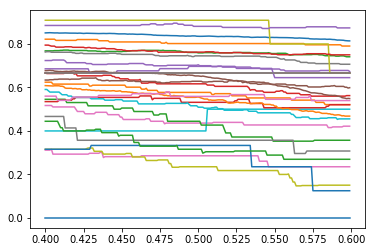

Probability threshold maximizing CV F1-score for each class:
[0.403 0.4   0.412 0.4   0.405 0.433 0.4   0.401 0.4   0.506 0.4   0.4
 0.4   0.462 0.484 0.4   0.404 0.4   0.428 0.4   0.43  0.4   0.4   0.4
 0.494 0.403 0.479 0.4  ]



BCE Individual F1-scores for each class:
[0.84781784 0.82568807 0.77134146 0.64285714 0.71565495 0.66200466
 0.49655172 0.77207392 0.90909091 0.5        0.         0.61935484
 0.52631579 0.52054795 0.88       0.66666667 0.31325301 0.46666667
 0.33898305 0.55895197 0.23529412 0.62571429 0.45714286 0.80681818
 0.72972973 0.67087011 0.60606061 0.66666667]
BCE Macro F1-score CV = 0.6011470420969867


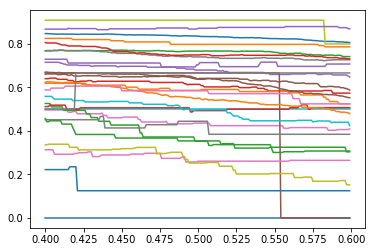

Probability threshold maximizing CV F1-score for each class:
[0.401 0.4   0.444 0.403 0.4   0.401 0.4   0.409 0.4   0.4   0.4   0.4
 0.4   0.568 0.557 0.4   0.4   0.436 0.402 0.4   0.416 0.401 0.4   0.4
 0.4   0.401 0.413 0.42 ]



Merge Individual F1-scores for each class:
[0.84757506 0.83783784 0.76829268 0.68181818 0.73125    0.66193853
 0.53246753 0.78313253 0.90909091 0.8        0.         0.65853659
 0.60550459 0.56790123 0.88209607 0.4        0.36       0.4
 0.43356643 0.62601626 0.52173913 0.63500678 0.5        0.80377358
 0.72222222 0.68431002 0.63414634 0.66666667]
Merge Macro F1-score CV = 0.6305317566365021


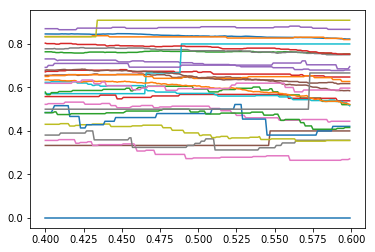

Probability threshold maximizing CV F1-score for each class:
[0.452 0.431 0.475 0.449 0.4   0.432 0.413 0.423 0.434 0.489 0.4   0.414
 0.467 0.488 0.56  0.547 0.409 0.427 0.41  0.404 0.524 0.4   0.477 0.4
 0.568 0.424 0.424 0.573]


In [28]:
T_avg =cal_val_f1_score(lastFullValPred_avg,'AVG') #f1 OTL remove
T_focal = cal_val_f1_score(lastFullValPred_focal,'FOCAL')
T_bce = cal_val_f1_score(lastFullValPred_bce,'BCE')
T_merge = cal_val_f1_score(lastFullValPred_merge,'Merge')

In [29]:
%%time
predicted = []
submit = pd.read_csv(DIR + '/sample_submission.csv')
P_avg = np.zeros((submit.shape[0], 28))
P_focal = np.zeros((submit.shape[0], 28))
P_bce = np.zeros((submit.shape[0], 28))
P_merge = np.zeros((submit.shape[0], 28))
P_soft = np.zeros((submit.shape[0], 29))
P_number = np.zeros((submit.shape[0], 1))
for i, name in enumerate(tqdm_notebook(submit['Id'])):
    path = os.path.join('./input/test/', name)
    image = data_generator.load_image(path)
    image = image.astype(np.float32) - mean_arr
    image /= 255.0
    avg,focal,bce,merge,soft,number = predict_tta(model,image,TTA)
    P_avg[i] = avg
    P_focal[i] =focal
    P_bce[i] = bce
    P_merge[i] = merge
    P_soft[i] = soft
    P_number[i] = number


Wall time: 1h 39s


In [30]:
PP_avg = np.array(P_avg)
PP_focal = np.array(P_focal)
PP_bce = np.array(P_bce)
PP_merge = np.array(P_merge)
PP_soft = np.array(P_soft)
PP_number = np.array(P_number)

In [31]:
PP_m = dict()
PP_m['merge'] = PP_merge
PP_m['focal'] = PP_focal
PP_m['bce'] = PP_bce
PP_m['soft'] = PP_soft
PP_m['number'] = PP_number
PP_m['best_thr'] = best_threshold
PP_m['local_score'] = best_val[27]
np.save('./probs/'+sub_prefix + '.npy',PP_m)

In [32]:
def make_sub(PP, T, name , SOFT = None):
    prediction = []
    if SOFT is None:
        PP_MAX = np.argmax(PP, axis=1)
    else:
        PP_MAX = np.argmax(SOFT[:,:28], axis=1)
    for row in tqdm_notebook(range(submit.shape[0])):    
        str_label = ''
        for col in range(PP.shape[1]):
            if(PP[row, col] < T[col]):
                str_label += ''
            else:
                str_label += str(col) + ' '
        if str_label == '':
            str_label += str(PP_MAX[row]) + ' '
        prediction.append(str_label.strip())
    submit['Predicted'] = np.array(prediction)
    sub_file_path = './subs/' + sub_prefix+ name+'.csv'
    submit.to_csv(sub_file_path, index=False)
    return np.array(prediction)

In [33]:
sub_avg = make_sub(PP_avg, T_avg,'AVG', SOFT=PP_soft)
sub_bce = make_sub(PP_bce, T_bce,'BCE', SOFT=PP_soft)
sub_focal = make_sub(PP_focal, T_focal,'FOCAL', SOFT=PP_soft)
sub_merge =make_sub(PP_merge, T_merge,'MERGE', SOFT=PP_soft)
sub_merge =make_sub(PP_merge, best_threshold,'BST_THR_MERGE', SOFT=PP_soft)

In [34]:
lb_prob = [
 0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
 0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
 0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
 0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
 0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
 0.222493880,0.028806584,0.010000000]
# I replaced 0 by 0.01 since there may be a rounding error leading to 0
def Count_soft(preds,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = 0.5*np.ones(28)
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y,
                                      wd*(p - 0.5)), axis=None)
    p, success = scopt.leastsq(error, params)
    return p

th_t = fit_test(PP_merge,lb_prob)
th_t[th_t<0.1] = 0.1
print('Thresholds: ',th_t)
print('Fractions: ',(pred > th_t).mean(axis=0))
print('Fractions (th = 0.5): ',(pred > 0.5).mean(axis=0))

#nothing class in public data set
class_list = [8,9,10,15,20,24,27]
for i in class_list:
    th_t[i] = best_threshold[i]
    
sub_merge = make_sub(PP_merge, th_t,'lbprobing',SOFT=PP_soft)

Thresholds:  [0.59767713 0.13345257 0.46454207 0.11962339 0.1        0.15442732
 0.13950165 0.28036004 0.1        0.10115819 0.1        0.11452054
 0.11833769 0.27396962 0.20702332 0.10880537 0.29395549 0.57490113
 0.31843699 0.16440289 0.31566744 0.41168093 0.1643989  0.27057744
 0.32433773 0.5442738  0.19167794 0.1120991 ]
Fractions:  [0.37045455 0.04188312 0.09902597 0.07142857 0.06980519 0.09415584
 0.04545455 0.08603896 0.00292208 0.00422078 0.00194805 0.04155844
 0.04837662 0.01655844 0.04318182 0.00422078 0.02337662 0.00324675
 0.02532468 0.05876623 0.00909091 0.11233766 0.03116883 0.09058442
 0.01525974 0.18051948 0.02987013 0.00162338]
Fractions (th = 0.5):  [0.41298701 0.03149351 0.09642857 0.03214286 0.04155844 0.05194805
 0.01493506 0.06818182 0.00162338 0.00064935 0.         0.01883117
 0.01396104 0.00974026 0.03733766 0.0012987  0.00974026 0.00551948
 0.01655844 0.02987013 0.0038961  0.08961039 0.01331169 0.07045455
 0.01331169 0.20714286 0.01071429 0.00064935]


In [35]:
sub_data_leak = pd.read_csv('./subs/'+sub_prefix+'BST_THR_MERGE.csv')

print('sub number : ', sub_data_leak.shape[0])
print('leak number : ',leak_data.shape[0])

for leak_idx in range(leak_data.shape[0]):
    for idx in range(sub_data_leak.shape[0]):
        if sub_data_leak['Id'][idx] == leak_data['ID'][leak_idx]:
            #print(sub_data_leak['Id'][idx])
            sub_data_leak['Predicted'][idx] = leak_data['LABELS'][leak_idx]
            break

sub_data_leak.head()
sub_data_leak.to_csv('./subs/'+sub_prefix+'BST_THR_MERGE_addleak.csv',index = False)

sub number :  11702
leak number :  259


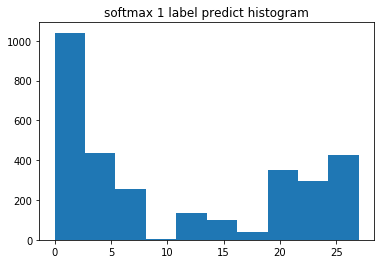

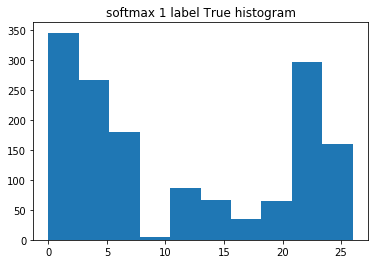

In [36]:
pred_soft_max_arg = np.argmax(lastFullValPred_soft[:,:28], axis=1)
plt.hist(pred_soft_max_arg)
plt.title('softmax 1 label predict histogram')
plt.show()

singleLabels = []
for label in lastFullValLabels:
    if label.sum() > 1:
        pass
    else:
        singleLabels.append(label)

singleLabels = np.array(singleLabels)
true_soft_max_arg = np.argmax(singleLabels, axis=1)
plt.hist(true_soft_max_arg)
plt.title('softmax 1 label True histogram')
plt.show()

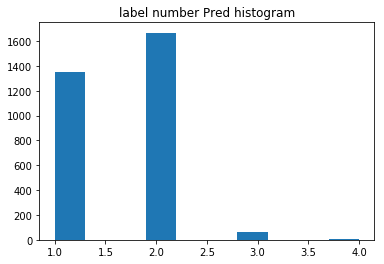

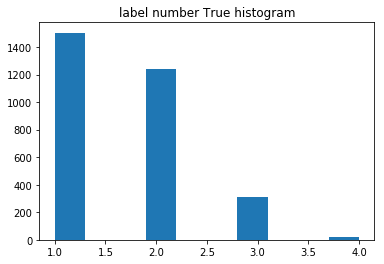

In [37]:
plt.hist(((lastFullValPred_number+0.1)*5).astype(np.uint8))
plt.title('label number Pred histogram')
plt.show()
plt.hist((lastFullValLabels.sum(axis=1)).astype(np.uint8))
plt.title('label number True histogram')
plt.show()